# Allie Garrison


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
conn = sqlite3.connect('zippedData/im.db')

bom_movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv")
rt_movie_info = pd.read_csv("zippedData/rt.movie_info.tsv", sep='\t')
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv', sep='\t',encoding='windows-1252')
tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv")
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", parse_dates=['release_date'])

In [3]:
## Making copy of movie budgets data frame for cleaning
tn_movie_budgets_clean = tn_movie_budgets.copy()

## turning the columns with dollar amounts into int types in millions of dollars
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['production_budget_in_millions'] = tn_movie_budgets_clean['production_budget_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['domestic_gross_in_millions'] = tn_movie_budgets_clean['domestic_gross_in_millions'].astype('int64') / 1000000

tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross'].str.strip('$').str.replace(',', '')
tn_movie_budgets_clean['worldwide_gross_in_millions'] = tn_movie_budgets_clean['worldwide_gross_in_millions'].astype('int64') / 1000000

## taking out all movies that were released before January 1, 2010
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['release_date'] >= "2010-01-01"]

## taking out all movies that did not make a profit
tn_movie_budgets_clean = tn_movie_budgets_clean[tn_movie_budgets_clean['domestic_gross_in_millions'] != 0]

In [9]:
## Creating columns with return on investment (ROI) for domestic and international revenue
tn_movie_budgets_clean['ROI_domestic'] = (tn_movie_budgets_clean['domestic_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100
tn_movie_budgets_clean['ROI_international'] = (tn_movie_budgets_clean['worldwide_gross_in_millions'] / tn_movie_budgets_clean['production_budget_in_millions']) * 100

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6,241.063875,1045.663875,58.710150,254.667286
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0,42.762350,149.762350,12.217814,42.789243
3,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6,459.005868,1403.013963,138.840250,424.384139
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317.0,620.181382,1316.721747,195.640815,415.369636
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220",306.0,936.662225,2053.311220,306.098766,671.016739


### 

In [16]:
## joining movie_basics and movie_ratings to create a data frame with title, runtime, genre, ratings, and votes
table_genre = pd.read_sql('''
SELECT mb.primary_title, 
        mb.runtime_minutes, 
        mb.genres, 
        mr.averagerating,
        mr.numvotes
FROM movie_basics AS mb
JOIN movie_ratings AS mr USING (movie_id)
''', conn)

In [17]:
## merging the cleaned tn.movie_budgets dataframe with table_genre on movie title
genre_ratings_budget = tn_movie_budgets_clean.merge(table_genre, how='inner', left_on='movie', right_on='primary_title')

In [18]:
genre_ratings_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_budget_in_millions,domestic_gross_in_millions,worldwide_gross_in_millions,ROI_domestic,ROI_international,primary_title,runtime_minutes,genres,averagerating,numvotes
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410.6,241.063875,1045.663875,58.710150,254.667286,Pirates of the Caribbean: On Stranger Tides,136.0,"Action,Adventure,Fantasy",6.6,447624
1,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350.0,42.762350,149.762350,12.217814,42.789243,Dark Phoenix,113.0,"Action,Adventure,Sci-Fi",6.0,24451
2,4,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330.6,459.005868,1403.013963,138.840250,424.384139,Avengers: Age of Ultron,141.0,"Action,Adventure,Sci-Fi",7.3,665594
3,7,2018-04-27,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",300.0,678.815482,2048.134200,226.271827,682.711400,Avengers: Infinity War,149.0,"Action,Adventure,Sci-Fi",8.5,670926
4,9,2017-11-17,Justice League,"$300,000,000","$229,024,295","$655,945,209",300.0,229.024295,655.945209,76.341432,218.648403,Justice League,120.0,"Action,Adventure,Fantasy",6.5,329135


# Cole Sussmeier

In [21]:
# create profit column
genre_ratings_budget['profit_in_millions'] = genre_ratings_budget['worldwide_gross_in_millions'] - genre_ratings_budget['production_budget_in_millions']

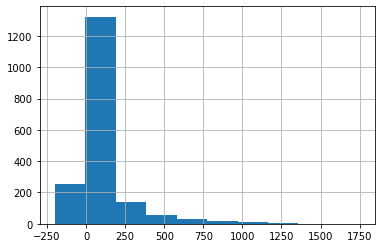

In [22]:
genre_ratings_budget['profit_in_millions'].round().hist();

In [23]:
avg_profit = genre_ratings_budget['profit_in_millions'].mean()
print(avg_profit)

94.15790165165491


In [24]:
action = genre_ratings_budget[genre_ratings_budget['genres'].str.contains('Action') == True]

In [25]:
from scipy import stats

In [26]:
stats.ttest_1samp(action['profit_in_millions'], popmean=avg_profit)

Ttest_1sampResult(statistic=5.621600148484867, pvalue=3.2669437136587626e-08)

In [ ]:
# avg profit from action is significantly different than avg profit overall